# Data Science Assignment 2
## Student ID: 19200174

## Task 1: Selecting three review categories and extracting data from them

Importing the packages needed

In [2]:
import pandas as pd
import numpy as np
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Function to extract all the links when a url is given

In [2]:
#Accessing the raw data from the HTML page and saving the variable html
def URL_links (url):
    response = urllib.request.urlopen(url)
    html = response.read().decode()
    
    #Converting the html data into soup format using BeautifulSoup
    soup = BeautifulSoup(html)
    Links = list() # Variable to save the links
    
    #for loop to get all links from the soup data
    for a in soup.find_all('a', href=True):
        Links.append(a['href'])
    
    return Links

In [3]:
#Getting all the links from the below html pages
url = 'http://mlg.ucd.ie/modules/yalp'
B = URL_links(url)#calling the function
Required_links = [] #List to store three links from which i will be scraping the reviews
names = ('cafes_list.html','hotels_list.html','restaurants_list.html') #Links from whcih i will be scarping the reviews
#for loop to get all the required links from links returned
for links in B:
    A = links
    if A in names:
        url_1 = url+'/'+A
        Required_links.append(url_1) # appending the links 

So below is a code block which is used to get all the required data like Title, Names, Dates, Rating and Review

In [ ]:
for i in range(len(Required_links)): #Loop to check all the three links from which reviews will be extracted
    A = str(Required_links[i])
    if 'cafes' in A:
        file = 'Cafes_data.csv' #to use to save the csv file with this name
    elif 'hotels' in A:
        file  = 'Hotels_data.csv'
    elif 'restaurants' in A:
        file = 'Restaurants_data.csv'
    Links_A = URL_links(Required_links[i])
    Links_A = Links_A[1:] #to exclude the first element which is the index link
    Dataset = pd.DataFrame(columns=['Shop','Name','Review Date','Rating', 'Review']) # creating a dataset to store the values
    for i in range(len(Links_A)):
        url_A = url+'/'+Links_A[i]#selecting the first link from the main link(basically first cafe or hotel or restaurant)
        response_A = urllib.request.urlopen(url_A)
        html_A = response_A.read().decode()
        soup_A = BeautifulSoup(html_A)
        Ratings = [img['alt'][0] for img in soup_A.find_all('img', alt = True)]#Saving all the ratings in this variable
        Review = list()
        for text in soup_A.find_all('p',{'class': 'review-text'}):
            Review.append(text.text)#saving Reviews in this variable
        Dates = list()
        for date in soup_A.find_all('b'):
            A = str(date)
            Dates.append(A[15:25])#saving all the dates into the variable
        Names = list()
        for name in soup_A.find_all('i'):
            Names.append(name.text)#saving all the names into the variable
        Title = list()
        for title in soup_A.find_all('title'):
            Title.append(title.text)#Sabving the title into the variable
        for i in range(len(Names)): #loop to store all the data into the datatset
            Dataset = Dataset.append({'Shop': Title, 'Name':Names[i], 'Review Date': Dates[i], 'Rating': Ratings[i], 'Review': Review[i]},  ignore_index=True)
    Dataset.to_csv(file, index=False)#Saving the dataset into csv file

## Task 2: Preprocessing the data extracted and to build a model and Predict.

First need to preprocess the data extracted

In [4]:
def Precprocessing_Data(df):
    #below code to clean the Shop Names in the Shop Column
    Shop_name = list(df['Shop'])
    Shop_new_name = []
    for i in range(len(Shop_name)):
        E = Shop_name[i]
        if "['Yalp " in E:
            E = E.replace("['Yalp ","")
            E = E.replace("']","")
            Shop_new_name.append(E)
        elif '["Yalp ' in E:
            E = E.replace('["Yalp ','')
            E = E.replace('"]','')
            Shop_new_name.append(E)
    df['Shop'] = Shop_new_name
    
    #Now lets compare the rating and make a new list which says if the rating is positive or negative
    Rating_C = list(df['Rating'])
    Ratings_pos_neg = []#This is used to store Positive for rating 5-4 and Negative for rating 1-3
    Ratings_model = []#This is used to store 1 for rating 5-4 and 0 for rating 1-3
    for i in range(len(Rating_C)):
        RR = Rating_C[i]
        if (RR == 1 or RR == 2 or RR == 3):#Checking if the rating is 1-3
            Ratings_pos_neg.append('Negative')#append Negative if is true
            Ratings_model.append('0')#append 0 if is true
        elif (RR == 4 or RR == 5):#Checking if the rating is 4-5
            Ratings_pos_neg.append('Positive')#append Positive if is true
            Ratings_model.append('1')#append 1 if is true
            
    df['Rating_Pos_Neg'] = Ratings_pos_neg#Creating a new column to store the data
    df['Rating_Model'] = Ratings_model#Creating a new column to store the data
    return df

Cleaning the extracted data using the function defined above. In the above function i have declared two new columns Rating_Pos_Neg, this is used to rate the review as Positive or Negative as per the rating received by the review. Another column is the Rating_Model, this i have declared so that i can use this while training the model as it is easy if we have binary values in the labels.

In [53]:
Cafes_Data = pd.read_csv('Cafes_data.csv')
Cafes_Cleaned_Data = Precprocessing_Data(Cafes_Data)

Cafes_Cleaned_Data.head()

,Shop,Name,Review Date,Rating,Review,Rating_Pos_Neg,Rating_Model
0,ABC Bakery Coffee Shop,Melanie Stanier,2018-06-19,4,Pros: Lots of items you would not expect from ...,Positive,1
1,ABC Bakery Coffee Shop,Jack Simmonds,2018-06-12,4,Best egg-tarts in town! There's really not muc...,Positive,1
2,ABC Bakery Coffee Shop,Alfred Durate,2018-06-03,2,I've been to ABC Bakery a few times since I re...,Negative,0
3,ABC Bakery Coffee Shop,Heidi Salvaggio,2018-03-18,1,"FYI, Closed Monday's New ownership for about 1...",Negative,0
4,ABC Bakery Coffee Shop,Robert Vanoy,2017-10-03,4,The inside may not look like much but they mak...,Positive,1


In [54]:
Hotels_Data = pd.read_csv('Hotels_data.csv')
Hotels_Cleaned_Data = Precprocessing_Data(Hotels_Data)

Hotels_Cleaned_Data.head()

,Shop,Name,Review Date,Rating,Review,Rating_Pos_Neg,Rating_Model
0,'Round Table Tours,Julie Aldridge,2016-12-22,5,Melissa took us on a tour of Asia in the space...,Positive,1
1,'Round Table Tours,Marilyn Mitchell,2016-06-06,5,With a group of seven of us visiting Montreal ...,Positive,1
2,'Round Table Tours,Maurice Hibbard,2015-08-12,5,Melissa is a gem! My fiancé found her tour on ...,Positive,1
3,'Round Table Tours,Una Barba,2015-07-29,5,A perfect day in Montreal! Melissa outfitted u...,Positive,1
4,'Round Table Tours,Janice Tyler,2014-09-21,5,I had a really great food truck tour with Meli...,Positive,1


In [55]:
Restaurants_Data = pd.read_csv('Restaurants_data.csv')
Restaurants_Cleaned_Data = Precprocessing_Data(Restaurants_Data)

Restaurants_Cleaned_Data.head()

,Shop,Name,Review Date,Rating,Review,Rating_Pos_Neg,Rating_Model
0,750ml Wines,Joan Boozer,2018-06-15,2,My husband and I had a rare afternoon off so w...,Negative,0
1,750ml Wines,Justin Woodard,2018-02-28,4,For years I thought this was only a wine store...,Positive,1
2,750ml Wines,Bette Diaz,2017-09-22,5,This place is so charming! I went with my husb...,Positive,1
3,750ml Wines,Preston Goodpasture,2017-09-15,5,We have been wanting to try this place for a c...,Positive,1
4,750ml Wines,Michael Kathan,2017-04-27,1,Decor looks ok but layout is too busy. Difficu...,Negative,0


The below task is the one used to pre process the raw data from the review comments and later on convert the review comments into string datatype. 

1. Removed stop words which are English Stop words imported using the text package. These stopwords wont be of any use.
2. Punctuations are also removed as they dont add meaning to the review text
3. White space is stripped.
4. Porter stemming is performed on the text

In [8]:
def Words_pre_processing(df):
    
    stopwords = nltk.corpus.stopwords.words('english')
    porter_stemmer = PorterStemmer()
    
    #Removing the punctuations  from them
    df['Review'] = df.Review.str.replace("[^\w\s]", "")
    
    #Stripping the white spaces from the words
    df['Review'] = df['Review'].str.strip()
    
    #Removing all the stop words from the reviews
    df['Review'] = df['Review'].apply(lambda x: [words for words in x.split() if words not in stopwords]) 
    
    # Stem every word in the review.
    df['Review'] = df['Review'].apply(lambda a: [porter_stemmer.stem(b) for b in a])
    
    #Coverting the review which is as list into string so that it can be given as an input to the Count Vectorizer
    df['Review'] = [','.join(map(str, s)) for s in df['Review']]
    
    return df

In [9]:
#Function to take the reviews from the dataset documents and tokenize the words and later on build a model, where the words
#from these reviews will be used to build a training model. Initially after using the count vectorizer on the words,
#we will divide this set of words into training and test sets with test set of size 30% of original word set and 
#train set will be 70% of the original word  set. We will use the Train data from traget as well as X to fit the selected model
#and will predict using the test data created initially. In the end this function will print a matrix with Accuracy, Precision
#Recall and F1- measure. In this function we will be passing the Dataset and the Classifier model we will be using.
def Model_to_predict(df):
    
    df = Words_pre_processing(df)
    
    documents = df["Review"]#Saving all the review comments in documents varibale
    target = df["Rating_Model"]#Saving all the Rating model in target varibale
    target.value_counts()#Counting the target values
    
    #using the Count vectorizer to tokenize all the collection of words and at the same time build a vocabulary
    vectorizer = CountVectorizer( min_df = 10, stop_words=None)
    X = vectorizer.fit_transform(documents)
    print(X.shape)
    
    #To print the distinct features in the vocabulary
    terms = vectorizer.get_feature_names()
    print("Vocabulary has %d distinct terms" % len(terms))
    
    # Display a set of sample terms
    print(terms[150:170])
    
    #Split the data, so that we have 70% in the training set and 30% in the test set:
    data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.3)
    
    #printing the number of Training and test set examples 
    print("Training set has %d examples" % data_train.shape[0] )
    print("Test set has %d examples" % data_test.shape[0] )
    
    #Fit and Predict Using the Classifier passed
    model = linear_model.LogisticRegression()
    model.fit(data_train, target_train)
    # Make a set of predictions for the training data
    y_pred = model.predict(data_test)
    
    print(classification_report(target_test, y_pred, target_names=["Positive","Negative"]))

In [10]:
# #Function to take the reviews from the dataset documents and tokenize the words and later on build a model, where the words
# #from these reviews will be used to build a training model. Initially after using the count vectorizer on the words,
# #we will divide this set of words into training and test sets with test set of size 30% of original word set and 
# #train set will be 70% of the original word  set. We will use the Train data from traget as well as X to fit the selected model
# #and will predict using the test data created initially. In the end this function will print a matrix with Accuracy, Precision
# #Recall and F1- measure. In this function we will be passing the Dataset and the Classifier model we will be using. 
# #We will be using cross validation in this function
# def Model_to_predict_Cross_val(df):
    
#     df = Words_pre_processing(df)
    
#     documents = df["Review"]#Saving all the review comments in documents varibale
#     target = df["Rating_Model"]#Saving all the Rating model in target varibale
#     target.value_counts()#Counting the target values
    
#     #using the Count vectorizer to tokenize all the collection of words and at the same time build a vocabulary
#     vectorizer = CountVectorizer( min_df = 10, stop_words=None )
#     X = vectorizer.fit_transform(documents)
#     print(X.shape)
    
#     # create a single classifier
#     model = linear_model.LogisticRegression()
#     # apply 2-fold cross-validation, measuring accuracy each time
#     acc_scores = cross_val_score(model, X, target, cv=7, scoring="f1_macro")
    
#     labels = [ "Fold %d" % i for i in range(1,len(acc_scores)+1) ]
#     s_acc = pd.Series(acc_scores, index = labels)   
#     print(s_acc)
#     print("Mean accuracy: %.4f" % s_acc.mean() )

## Below are the Three classifier models used on all the three datasets and the accuracy (F1-measure) are displayed for all the three different classifiers

## Cafes Dataset

In [11]:
Model_to_predict(Cafes_Cleaned_Data)

(2000, 1479)
Vocabulary has 1479 distinct terms
['black', 'bland', 'blend', 'block', 'blow', 'blt', 'blue', 'blueberri', 'board', 'boba', 'bold', 'bomb', 'bonu', 'book', 'booth', 'both', 'bother', 'bottl', 'bottom', 'bought']
Training set has 1400 examples
Test set has 600 examples
              precision    recall  f1-score   support

    Positive       0.77      0.62      0.69       159
    Negative       0.87      0.93      0.90       441

    accuracy                           0.85       600
   macro avg       0.82      0.78      0.80       600
weighted avg       0.85      0.85      0.85       600



## Hotels Dataset

In [13]:
Model_to_predict(Hotels_Cleaned_Data)

(2000, 1727)
Vocabulary has 1727 distinct terms
['awar', 'away', 'awesom', 'awhil', 'az', 'babi', 'back', 'backpack', 'bacon', 'bad', 'bag', 'bagel', 'baggag', 'band', 'bank', 'bar', 'bare', 'bartend', 'base', 'basic']
Training set has 1400 examples
Test set has 600 examples
              precision    recall  f1-score   support

    Positive       0.90      0.85      0.87       239
    Negative       0.90      0.94      0.92       361

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.90       600
weighted avg       0.90      0.90      0.90       600



## Restaurants Dataset

In [14]:
Model_to_predict(Restaurants_Cleaned_Data)

(2000, 1555)
Vocabulary has 1555 distinct terms
['best', 'better', 'beverag', 'beyond', 'big', 'bigger', 'bill', 'birthday', 'biscuit', 'bit', 'bite', 'black', 'blame', 'bland', 'block', 'blue', 'board', 'boil', 'bomb', 'bone']
Training set has 1400 examples
Test set has 600 examples
              precision    recall  f1-score   support

    Positive       0.83      0.78      0.80       246
    Negative       0.85      0.89      0.87       354

    accuracy                           0.84       600
   macro avg       0.84      0.83      0.84       600
weighted avg       0.84      0.84      0.84       600



In [16]:
#Model_to_predict_Cross_val(Cafes_Cleaned_Data)

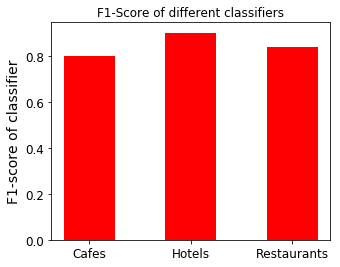

In [3]:
values = [0.80, 0.90, 0.84]
names = ['Cafes','Hotels','Restaurants']
plt.figure(figsize=(5,4))
# set up the bar chart
plt.bar(names, values, color="Red", width=0.5)
plt.title("F1-Score of different classifiers", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Below is the table with Different accuracy measure for all three datasets

<div align="center"><b>Accuracy table for all three models for all three Dataset</b></div></br>

|Model Used|Precision|Recall|F1 score|
| --- | --- | --- |--- |
|Logistic Regression for Cafes Dataset|0.82|0.78|0.80|
|Logistic Regression for Hotels Dataset|0.90|0.89|0.90|
|Logistic Regression for Restaurants Dataset|0.84|0.83|0.84|

As seen in the above tables, it is evident enough that F1-measure with Logistic regression model is the one which should be used on all the datsets. As the dataset we are using is an imbalanced dataset we cannot really rely on the accuarcy or the Precison/Recall. So for an imbalanced dataset we use the F1-Score or measure for evaluation where we can compare macro average of all three datasets. So in our analysis we are gonna select Logistic regression as the model with F1-Meausure as it gives the highest accuracy when compared with the other two accuracy parameters and this behaviour is seen through all the three datatsets.

1. The Macro F1-score for Cafes dataset: 80%
2. The Macro F1-score for Hotels dataset: 90%
3. The Macro F1-score for Restaurants dataset: 84%

# Task 3:  Evaluate the performance of each of your three classification models when applied to data from the other two selected categories.

Following mix match of train and test dataset will be done in this task and the mix and match are defined below:
1. Training dataset A and testing the on other dataset B and C.
2. Training dataset B and testing the on other dataset A and C.
3. Training dataset C and testing the on other dataset A and B.

In [56]:
df = Cafes_Cleaned_Data#Copying the dataframe into a temporary variable
df1 = Hotels_Cleaned_Data#Copying the dataframe into a temporary variable
df2 = Restaurants_Cleaned_Data#Copying the dataframe into a temporary variable

df_1 = Words_pre_processing(df)#Using the preprocessing function on the review text
df_2 = Words_pre_processing(df1)#Using the preprocessing function on the review text
df_3 = Words_pre_processing(df2)#Using the preprocessing function on the review text
    
#For Dataset 1
documents = df_1["Review"]#Saving all the review comments in documents varibale from dataset 1
target = df_1["Rating_Model"]#Saving all the Rating model in target varibale from dataset 1
    
#For Dataset 2
documents1 = df_2["Review"]#Saving all the review comments in documents varibale from dataset 2
target1 = df_2["Rating_Model"]#Saving all the Rating model in target varibale from dataset 2

#For Dataset 3
documents2 = df_3["Review"]#Saving all the review comments in documents varibale from dataset 3
target2 = df_3["Rating_Model"]#Saving all the Rating model in target varibale from dataset 3

The part where it gets tricky is, when we fit and transform using count vectorizer directly on each review documents we will be get different shape. So to avoid this problem i am using pipeline. Where i will fit using the 1st dataset on which i will train and transform all the rest datasets.

In [57]:
from sklearn.decomposition import SparsePCA
#using the Count vectorizer to tokenize all the collection of words and at the same time build a vocabulary
vectorizer = CountVectorizer( min_df = 10, stop_words=None)
transform = vectorizer.fit(documents)#fitting using the first dataset
X_11 = transform.transform(documents)#tranform using the first dataset

X_12 = transform.transform(documents1)#tranform using the first dataset

X_13 = transform.transform(documents2)#tranform using the first dataset

In [63]:
transform2 = vectorizer.fit(documents1)#fitting using the second dataset
X_22 = transform.transform(documents1)#tranform using the second dataset

X_21 = transform.transform(documents)#tranform using the second dataset

X_23 = transform.transform(documents2)#tranform using the second dataset

In [59]:
transform3 = vectorizer.fit(documents2)#fitting using the third dataset
X_33 = transform.transform(documents2)#tranform using the third dataset

X_31 = transform.transform(documents)#tranform using the third dataset

X_32 = transform.transform(documents1)#tranform using the third dataset

In [60]:
#Function to take the reviews from the dataset documents and tokenize the words and later on build a model, where the words
#from these reviews will be used to build a training model. Initially after using the count vectorizer on the words,
#we will divide this set of words into training and test sets with test set of size 30% of original word set and 
#train set will be 70% of the original word  set. We will use the Train data from traget as well as X to fit the selected model
#and will predict using the test data created initially. In the end this function will print a matrix with Accuracy, Precision
#Recall and F1- measure. In this function we will be passing the Dataset and the Classifier model we will be using.
def Model_to_fit_onedataset_predict_Another_Dataset(X,target,X1,target1):
    
    #Fit and Predict Using the Classifier passed
    model = linear_model.LogisticRegression()
    model.fit(X, target)
    # Make a set of predictions for the training data
    y_pred = model.predict(X1)
    
    print(classification_report(target1, y_pred, target_names=["Positive","Negative"]))

## Training dataset Cafes and tested on other dataset Hotels and Restaurants.

In [61]:
Model_to_fit_onedataset_predict_Another_Dataset(X_11,target,X_12,target1)

              precision    recall  f1-score   support

    Positive       0.76      0.80      0.78       824
    Negative       0.85      0.82      0.84      1176

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



In [62]:
Model_to_fit_onedataset_predict_Another_Dataset(X_11,target,X_13,target2)

              precision    recall  f1-score   support

    Positive       0.85      0.78      0.81       838
    Negative       0.85      0.90      0.87      1162

    accuracy                           0.85      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.85      0.85      2000



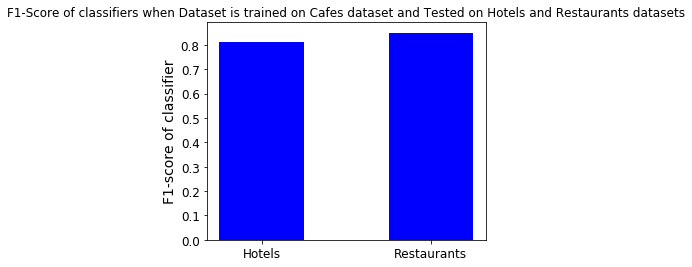

In [86]:
values = [0.81, 0.84]
names = ['Hotels','Restaurants']
plt.figure(figsize=(5,4))
# set up the bar chart
plt.bar(names, values, color="Blue", width=0.5)
plt.title("F1-Score of classifiers when Dataset is trained on Cafes dataset and Tested on Hotels and Restaurants datasets", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Training dataset Hotels and tested on other dataset Cafes and Restaurants.

In [64]:
Model_to_fit_onedataset_predict_Another_Dataset(X_22,target1,X_21,target)

              precision    recall  f1-score   support

    Positive       0.66      0.71      0.69       538
    Negative       0.89      0.87      0.88      1462

    accuracy                           0.83      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.83      0.83      0.83      2000



In [65]:
Model_to_fit_onedataset_predict_Another_Dataset(X_22,target1,X_23,target2)

              precision    recall  f1-score   support

    Positive       0.81      0.76      0.79       838
    Negative       0.84      0.87      0.85      1162

    accuracy                           0.83      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.83      0.83      0.83      2000



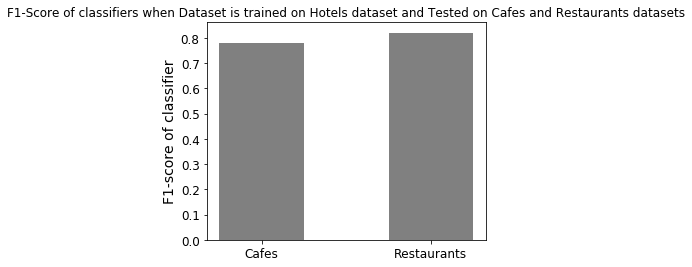

In [4]:
values = [0.78, 0.82]
names = ['Cafes','Restaurants']
plt.figure(figsize=(5,4))
# set up the bar chart
plt.bar(names, values, color="Grey", width=0.5)
plt.title("F1-Score of classifiers when Dataset is trained on Hotels dataset and Tested on Cafes and Restaurants datasets", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Training dataset Restaurants and tested on other dataset Cafes and Hotels.

In [66]:
Model_to_fit_onedataset_predict_Another_Dataset(X_33,target2,X_31,target)

              precision    recall  f1-score   support

    Positive       0.74      0.79      0.76       538
    Negative       0.92      0.90      0.91      1462

    accuracy                           0.87      2000
   macro avg       0.83      0.84      0.84      2000
weighted avg       0.87      0.87      0.87      2000



In [67]:
Model_to_fit_onedataset_predict_Another_Dataset(X_33,target2,X_32,target1)

              precision    recall  f1-score   support

    Positive       0.75      0.86      0.80       824
    Negative       0.89      0.79      0.84      1176

    accuracy                           0.82      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.83      0.82      0.82      2000



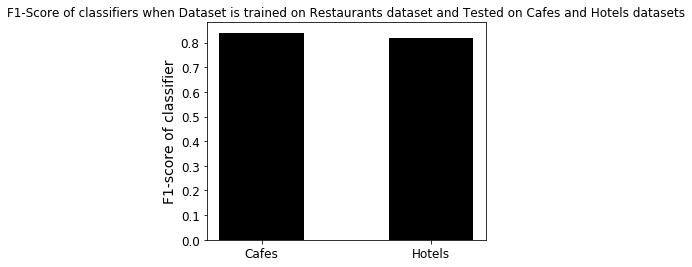

In [5]:
values = [0.84, 0.82]
names = ['Cafes','Hotels']
plt.figure(figsize=(5,4))
# set up the bar chart
plt.bar(names, values, color="Black", width=0.5)
plt.title("F1-Score of classifiers when Dataset is trained on Restaurants dataset and Tested on Cafes and Hotels datasets", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Conclusion for Task 3

Cafes Model: In this model, i have trained the model using the cafes dataset and tested the trained model using the Hotels and Restaurants datasets. The F1-score for the Hotel dataset is 81% and for the Restaurants dataset it is 84%.

Hotels Model: In this model, i have trained the model using the hotels dataset and tested the trained model using the Cafes and Restaurants datasets. The F1-score for the Hotel dataset is 78% and for the Restaurants dataset it is 82%.

Restaurants Model: In this model, i have trained the model using the Restaurants dataset and tested the trained model using the Cafes and Hotels datasets. The F1-score for the Hotel dataset is 84% and for the Restaurants dataset it is 82%.

So some interesting facts are seen when we trained on one dataset and tested on another, like in case of Cafe model, we can say the cafes and restaurants dataset return highes accuracy when ran on each other, this means that there are many similar words in these two datasets. In other meaning, it means that people who have writtem review for both the datasets, have used words which are similar. This is the reason why the accuracy is higher when these two datasets are used against each other.

Another interesting fact in this analysis is that when we trained the model on hotels dataset and predicted for Cafes and Restaurant dataset, the accuracy for cafes dataset is low and its higher for the Restaurant dataset. This maybe beacuse the hotel and cafe dataset have less words in common and hotel and Restaurant have more words in common. In other words people have used words which are less similar while writing review for cafes and hotels and people have used words which are more similar in hotels and Restaurant datasets while writing review.

One more interesting fact in this analysis is that when we trained the model on hotels dataset and predicted for Restaurant dataset and vice versa, the accuracy was same for both datasets. This is maybe because all the words in hotel dataset are present in restaurant datasets. That maybe one of the reason we are getting the accuracy.

In [7]:
! jupyter nbconvert --to html Assignment_2_19200174.ipynb

[NbConvertApp] Converting notebook Assignment_2_19200174.ipynb to html
[NbConvertApp] Writing 429843 bytes to Assignment_2_19200174.html
